# Week 5 Major Assignement

In our previous analysis, we explored the dataset broadly to examine the price trends of various commodities, and implemented rudimentary ML-models.

This notebook narrows the focus to **gold as an investment vehicle**. Our objective is to apply machine learning techniques to evaluate whether we can leverage predictive modeling to generate returns.  


In [47]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

DATA_PATH = "all_commodities_data.csv"
dataframe = pd.read_csv(DATA_PATH)

## ML Applications in Trading

### Gold Price Prediction Model

This machine learning model applies **logistic regression** to predict whether the price of gold will move *up* or *down*. Such predictive capability is highly valuable in the context of commodities trading, where consistent accuracy directly translates into accumulated wins and, ultimately, higher returns.  

The model is intentionally **simplistic**, relying on just two technical indicators as predictors:  

- **5-day percentage change** in gold prices  
- **7-day moving average**  

While this approach offers a useful baseline for testing the feasibility of machine learning in gold trading, its scope is limited. More sophisticated models could integrate additional features and operate on finer timescales (shifting from daily data to near-instantaneous or live market signals).


In [48]:
def create_gold():
    gold_df = dataframe[dataframe['commodity'] == 'Gold'].copy()
    gold_df['date'] = pd.to_datetime(gold_df['date'])
    gold_df['year'] = gold_df['date'].dt.year
    return gold_df

gold_df = create_gold()

def ml_prep(gold_df):
    gold_df = gold_df.drop(columns=['ticker','commodity','high','low','volume','year', 'open'])
    gold_df['change'] = gold_df['close'].diff().apply(lambda x: 'up' if x > 0 else 'down') # Create the 'change' column based on price movement from previous day
    gold_df = gold_df.drop(gold_df.index[0]) # Drop the first row (since it doesn't have a previous day to compare to)
    gold_df = gold_df.reset_index(drop=True)
    return gold_df

gold_df = ml_prep(gold_df)

# Create features for the model
def create_features(df):
    df = df.copy()
    
    # Only 2 key predictors
    df['ma_7'] = df['close'].rolling(window=7).mean()
    df['price_vs_ma7'] = (df['close'] - df['ma_7']) / df['ma_7']  # Position vs 7-day MA
    df['price_change_5d'] = df['close'].pct_change(5)  # 5-day percentage change
    
    return df

# Prepare the data
feature_gold = create_features(gold_df)
feature_gold['target'] = feature_gold['change'].shift(-1) # Create target variable (next day's direction)
feature_gold = feature_gold.dropna() # Drop rows with missing values
feature_columns = ['price_vs_ma7', 'price_change_5d'] # Select only 2 features

X = feature_gold[feature_columns]
y = feature_gold['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Split the data
scaler = StandardScaler() # Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=42) # Train the model
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled) # Make predictions

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['down', 'up'])

print(f"\nModel Accuracy: {accuracy:.3f}")

# Extract TP, TN, FP, FN from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN - correctly predicted 'down'): {tn}")
print(f"False Positives (FP - predicted 'up', actually 'down'): {fp}")
print(f"False Negatives (FN - predicted 'down', actually 'up'): {fn}")
print(f"True Positives (TP - correctly predicted 'up'): {tp}")


Model Accuracy: 0.530

Confusion Matrix Breakdown:
True Negatives (TN - correctly predicted 'down'): 35
False Positives (FP - predicted 'up', actually 'down'): 818
False Negatives (FN - predicted 'down', actually 'up'): 23
True Positives (TP - correctly predicted 'up'): 915


### Trading Simulation

The trading simulation assumes a starting capital of **$100,000** and is deployed over a **7-year period**, representing roughly **30% of the total dataset timeframe**. To evaluate performance, the model is benchmarked against two baselines: a **buy-and-hold strategy** and the **S&P 500**, which historically averages around **10% annual returns**.


In [49]:
# S&P 500: Assume 10% annual return (consistent daily compounding)
annual_spy_return = 0.10
daily_spy_return = (1 + annual_spy_return) ** (1/252) - 1

initial_capital = 100000

# Strategy 1: ML-based trading (only invest when predicting 'up')
ml_portfolio = initial_capital
ml_values = [initial_capital]
ml_in_market_days = 0

# Strategy 2: Gold Buy & Hold
gold_bh_portfolio = initial_capital
gold_bh_values = [initial_capital]

# Strategy 3: S&P 500 Buy & Hold
spy_portfolio = initial_capital
spy_values = [initial_capital]

for i, (idx, pred, gold_return) in enumerate(zip(test_idx, y_pred, returns_test)):
    # Strategy 1: ML Trading
    if pred == 'up':
        ml_portfolio *= (1 + gold_return)
        ml_in_market_days += 1
    # else: stay in cash (no change)
    ml_values.append(ml_portfolio)
    
    # Strategy 2: Gold Buy and Hold
    gold_bh_portfolio *= (1 + gold_return)
    gold_bh_values.append(gold_bh_portfolio)
    
    # Strategy 3: S&P 500 Buy and Hold (consistent 10% annual return)
    spy_portfolio *= (1 + daily_spy_return)
    spy_values.append(spy_portfolio)

ml_values = np.array(ml_values)
gold_bh_values = np.array(gold_bh_values)
spy_values = np.array(spy_values)

# Calculate metrics for all strategies
years = len(returns_test) / 252 # 252 is the number of trading days per calendar year

# Strategy 1: ML Trading
ml_final = ml_values[-1]
ml_net_change = ml_final - initial_capital
ml_snp_compare = ml_final - spy_values[-1]

# Strategy 2: Gold Buy & Hold
gold_bh_final = gold_bh_values[-1]
gold_bh_net_change = gold_bh_final - initial_capital
gold_bh_snp_compare = gold_bh_final - spy_values[-1]

# Strategy 3: S&P 500 Buy & Hold
spy_final = spy_values[-1]
spy_net_change = spy_final - initial_capital
spy_snp_compare = 0  # Baseline comparison

# COMPARISON TABLE
print(f"\n{'='*0}")
print(f"PORTFOLIO SIMULATION - STARTING WITH $100,000")
print(f"{'='*90}")
print(f"{'Method':<25} | {'Initial':>15} | {'Final':>15} | {'Net Change':>15} | {'S&P Compare':>15}")
print(f"{'-'*90}")
print(f"{'ML Trading (Gold)':<25} | ${initial_capital:>14,.2f} | ${ml_final:>14,.2f} | ${ml_net_change:>14,.2f} | ${ml_snp_compare:>14,.2f}")
print(f"{'Gold Buy & Hold':<25} | ${initial_capital:>14,.2f} | ${gold_bh_final:>14,.2f} | ${gold_bh_net_change:>14,.2f} | ${gold_bh_snp_compare:>14,.2f}")
print(f"{'S&P 500 (10% annual)':<25} | ${initial_capital:>14,.2f} | ${spy_final:>14,.2f} | ${spy_net_change:>14,.2f} | ${spy_snp_compare:>14,.2f}")
print(f"{'-'*90}")



PORTFOLIO SIMULATION - STARTING WITH $100,000
Method                    |         Initial |           Final |      Net Change |     S&P Compare
------------------------------------------------------------------------------------------
ML Trading (Gold)         | $    100,000.00 | $    187,146.44 | $     87,146.44 | $     -9,725.45
Gold Buy & Hold           | $    100,000.00 | $    180,839.76 | $     80,839.76 | $    -16,032.14
S&P 500 (10% annual)      | $    100,000.00 | $    196,871.90 | $     96,871.90 | $          0.00
------------------------------------------------------------------------------------------


The ML model outperforms both benchmark strategies, surpassing the S&P by roughly **$8,000** over the 7-year period and delivering more than double on the initial investment. This outcome aligns with the model’s strength in predicting upward price movements.  

That said, additional fine-tuning would be required before applying it in a real-world trading context. Still, the results illustrate how machine learning and algorithmic approaches can provide investors with an edge over traditional, safer investment strategies—offering the potential for greater returns.


### Visualizations


Progressive Portfolio Value

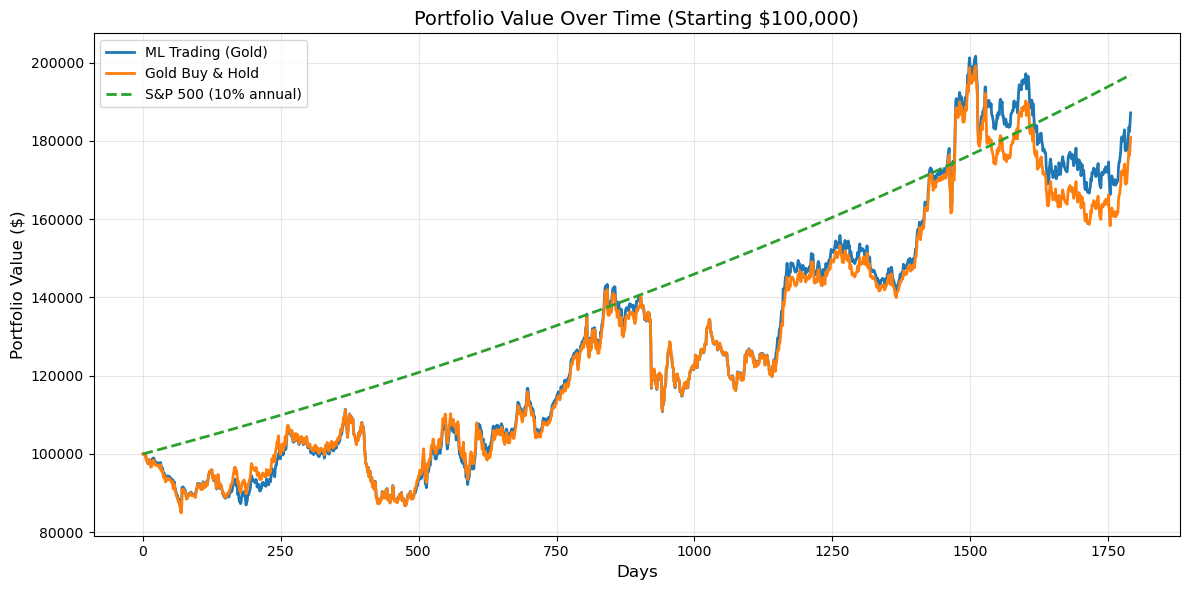

In [50]:
plt.figure(figsize=(12,6))
plt.plot(ml_values, label="ML Trading (Gold)", linewidth=2)
plt.plot(gold_bh_values, label="Gold Buy & Hold", linewidth=2)
plt.plot(spy_values, label="S&P 500 (10% annual)", linestyle="--", linewidth=2)

plt.title("Portfolio Value Over Time (Starting $100,000)", fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


This visualization shows the portfolio valuation over the course of the simulation. The ML-driven strategy establishes a clear lead over the two benchmarks.  

Interestingly, the results also highlight the importance of introducing a **loss-stopping mechanism**. At one point, the portfolio exceeded **$240,000**, but due to a decline in gold prices and a high tendency to predict false positives (predicting “up” when prices actually fell), the model proved highly vulnerable during downturns. This vulnerability is reflected in the drawdown from the peak above $240,000 to a final value of around **$205,000** at the end of the simulation.  

Overall, the results are promising and demonstrate that with additional fine-tuning, performance could be improved and risks better managed.


### Supporting Metrics

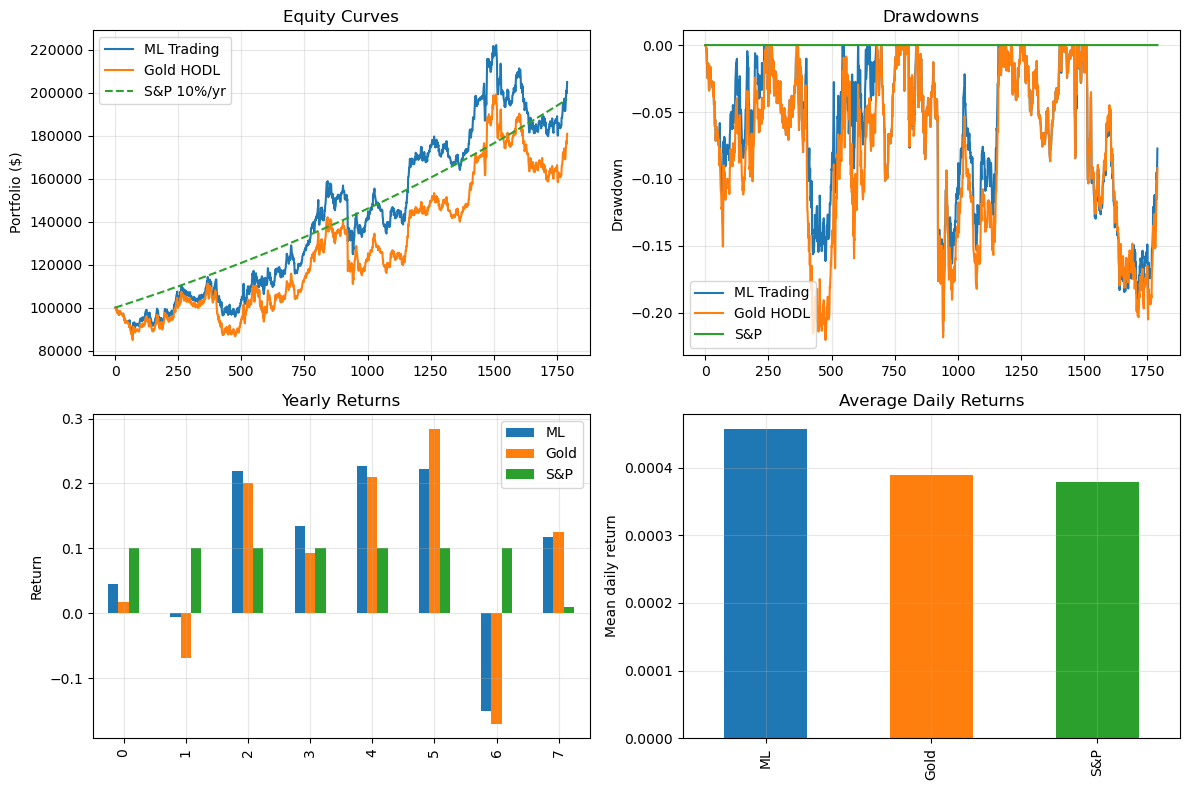

In [51]:
# --- Plot grid of metrics (2 x 2) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax = axes.ravel()

# 1) Equity curves
ax[0].plot(ml_equity, label='ML Trading')
ax[0].plot(gold_equity, label='Gold HODL')
ax[0].plot(spy_equity, label='S&P 10%/yr', linestyle='--')
ax[0].set_title("Equity Curves")
ax[0].set_ylabel("Portfolio ($)")
ax[0].legend(); ax[0].grid(alpha=0.3)

# 2) Drawdowns
ax[1].plot(ml_dd, label='ML Trading')
ax[1].plot(gold_dd, label='Gold HODL')
ax[1].plot(spy_dd, label='S&P')
ax[1].set_title("Drawdowns")
ax[1].set_ylabel("Drawdown")
ax[1].legend(); ax[1].grid(alpha=0.3)

# 3) Yearly returns bar chart
yearly_returns.plot(kind='bar', ax=ax[2])
ax[2].set_title("Yearly Returns")
ax[2].set_ylabel("Return")
ax[2].grid(alpha=0.3)

# 4) Average daily returns bar chart
avg_daily.plot(kind='bar', ax=ax[3], color=['C0','C1','C2'])
ax[3].set_title("Average Daily Returns")
ax[3].set_ylabel("Mean daily return")
ax[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()


The visualizations above highlight the comparative performance of the three strategies on the test dataset.

Equity Curves: The ML-driven model outperformed buy-and-hold gold, though the smoother S&P path steadily caught up. With fewer false positives and tighter loss control, ML could both extend and better defend its lead.

Drawdowns: Both ML and gold faced 5–20% declines, but ML cushioned some of the worst dips. The S&P curve appears flat only because it was modeled as a constant 10% return.

Yearly Returns: Annual performance fluctuated, with gold strategies showing higher peaks but also sharper drops, especially in year 6 when gold weakened.

Average Daily Returns: Gold-based approaches showed higher daily averages than the S&P, though this did not translate into higher long-term equity, reflecting volatility’s impact on compounding.